## About the model
This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) model by Alexey Dosovitskiy et al. for image classification, and demonstrates it on the CIFAR-100 dataset. The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers.

![vit](https://neurohive.io/wp-content/uploads/2020/10/rsz_cov.png)

In [2]:
import numpy as np 
import pandas as pd 
import os
import gc
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


AUTOTUNE = tf.data.experimental.AUTOTUNE

## Reshape images to 512x512

In [3]:
TRAIN_PATH = 'resized_train/'
DF_TRAIN = pd.read_csv('trainLabels.csv', dtype='str')
DF_TRAIN['image_path'] = TRAIN_PATH + DF_TRAIN["image"] + ".jpeg" 
DF_TRAIN.head()

image level                    image_path
0    10_left     0    resized_train/10_left.jpeg
1   10_right     0   resized_train/10_right.jpeg
2   100_left     0   resized_train/100_left.jpeg
3  100_right     0  resized_train/100_right.jpeg
4   102_left     0   resized_train/102_left.jpeg

In [4]:
classes = {0 : "No DR",
           1 : "Mild",
           2 : "Moderate",
           3 : "Severe",
           4 : "Proliferative"}

In [ ]:
!mkdir -p ./train_imgs_reshaped


In [5]:
DF_TRAIN['image_path'][0]

'resized_train/10_left.jpeg'

Image Resizing Problem

In [25]:
output_dir = './test_reshaped'
for img in DF_TRAIN['image_path']:
    # Open and resize the image
    image = Image.open(img)
    image = image.resize((512, 512), Image.LANCZOS)        
    # Generate the output file path
    img_outfpath = os.path.join(output_dir, os.path.basename(img))
    # Save the resized image
    image.save(fp=img_outfpath)
    



In [ ]:
import os
from PIL import Image

# Create output directory if it does not exist
output_dir = "test_reshaped"
print(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Process and save images
for img in DF_TRAIN['image_path']:
    try:
        # Print the image path for debugging
        print(f"Processing: {img}")

        # Open and resize the image
        image = Image.open(img)
        image = image.resize((512, 512), Image.LANCZOS)
        
        # Generate the output file path
        img_outfpath = os.path.join(output_dir, os.path.basename(img))

        # Save the resized image
        image.save(fp=img_outfpath)
        print(f"Saved: {img_outfpath}")
    except FileNotFoundError:
        print(f"File not found, skipping: {img}")
        continue
    except Exception as e:
        print(f"Error processing {img}: {e}")
        continue
'resized_train_cropped/'.split('/')[-1]

In [ ]:









# from PIL import Image

# for img in DF_TRAIN['image_path']:
#     img_outfpath = "./train_imgs_reshaped" + img.split('/')[-1]
#     image = Image.open(img)
#     image = image.resize((512,512),Image.LANCZOS)
#     image.save(fp=img_outfpath)

## Define DFs for reshaped images

One hot encode diagnosis

In [6]:
TRAIN_PATH_RS = 'train_imgs_reshaped/'
DF_TRAIN_RS = pd.read_csv('trainLabels.csv', dtype='str')
DF_TRAIN_RS['image_path'] = TRAIN_PATH_RS + DF_TRAIN_RS["image"] + ".jpeg" 
DF_TRAIN_RS.head()

image level                          image_path
0    10_left     0    train_imgs_reshaped/10_left.jpeg
1   10_right     0   train_imgs_reshaped/10_right.jpeg
2   100_left     0   train_imgs_reshaped/100_left.jpeg
3  100_right     0  train_imgs_reshaped/100_right.jpeg
4   102_left     0   train_imgs_reshaped/102_left.jpeg

In [7]:
#Source: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [8]:
print(DF_TRAIN_RS.columns)

Index(['image', 'level', 'image_path'], dtype='object')


In [9]:
res = encode_and_bind(DF_TRAIN_RS, 'level')

In [10]:


# Identify boolean columns
boolean_columns = [col for col in res.columns if res[col].dtype == bool]

# Convert boolean values to 0 and 1
res[boolean_columns] = res[boolean_columns].astype(int)




In [11]:
res



image                            image_path  level_0  level_1  \
0         10_left      train_imgs_reshaped/10_left.jpeg        1        0   
1        10_right     train_imgs_reshaped/10_right.jpeg        1        0   
2        100_left     train_imgs_reshaped/100_left.jpeg        1        0   
3       100_right    train_imgs_reshaped/100_right.jpeg        1        0   
4        102_left     train_imgs_reshaped/102_left.jpeg        1        0   
...           ...                                   ...      ...      ...   
3345  13821_right  train_imgs_reshaped/13821_right.jpeg        1        0   
3346  13945_right  train_imgs_reshaped/13945_right.jpeg        0        1   
3347  14262_right  train_imgs_reshaped/14262_right.jpeg        1        0   
3348  14595_right  train_imgs_reshaped/14595_right.jpeg        1        0   
3349  14921_right  train_imgs_reshaped/14921_right.jpeg        1        0   

      level_2  level_3  level_4  
0           0        0        0  
1           0        0        0  
2           0        0        0  
3           0        0        0  
4           0        0        0  
...       ...      ...      ...  
3345        0        0        0  
3346        0        0        0  
3347        0        0        0  
3348        0        0        0  
3349        0        0        0  

[3350 rows x 7 columns]

In [12]:
classes = {"level_0" : "No DR",
           "level_1" : "Mild",
           "level_2" : "Moderate",
           "level_3" : "Severe",
           "level_4" : "Proliferative"}

In [13]:
res.rename(columns=classes, inplace=True)
res.head()

image                          image_path  No DR  Mild  Moderate  \
0    10_left    train_imgs_reshaped/10_left.jpeg      1     0         0   
1   10_right   train_imgs_reshaped/10_right.jpeg      1     0         0   
2   100_left   train_imgs_reshaped/100_left.jpeg      1     0         0   
3  100_right  train_imgs_reshaped/100_right.jpeg      1     0         0   
4   102_left   train_imgs_reshaped/102_left.jpeg      1     0         0   

   Severe  Proliferative  
0       0              0  
1       0              0  
2       0              0  
3       0              0  
4       0              0

In [14]:
res.columns

Index(['image', 'image_path', 'No DR', 'Mild', 'Moderate', 'Severe',
       'Proliferative'],
      dtype='object')

In [15]:
target = np.array(res[['No DR', 'Mild', 'Moderate', 'Severe',
       'Proliferative']])

In [16]:
X_train, X_test, y_train, y_test  = train_test_split(res['image_path'], target, test_size=0.33, random_state=42)
print(f"X_train shape: {X_train.shape}- y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}- y_test shape: {y_test.shape}")

X_train shape: (2244,)- y_train shape: (2244, 5)
X_test shape: (1106,)- y_test shape: (1106, 5)


(-0.5, 511.5, 511.5, -0.5)

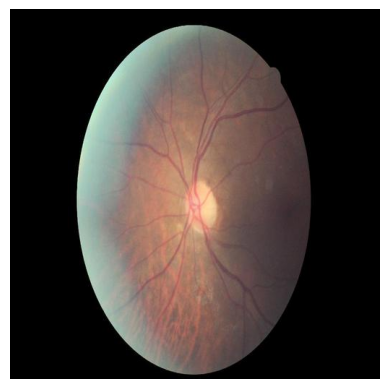

In [17]:
from PIL import Image
image_path = Image.open('./train_imgs_reshaped/10_left.jpeg')
plt.imshow(image_path)
plt.axis("off")

## Configure the hyperparameters

In [18]:
num_classes = 5
input_shape = (512, 512, 3)
learning_rate = 1e-4 #0.001
weight_decay = 0.0001
batch_size = 8 #256
num_epochs = 1
steps_per_epoch = 5
# We'll resize input images to this size
image_size =  256 
# Size of the patches to be extract from the input images
patch_size = 7 
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 8
# Size of the dense layers of the final classifier
mlp_head_units = [56, 28] #[1024, 512]  

In [19]:
num_patches

1296

In [20]:
@tf.function
def load(image_file, target):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)

    image_ = tf.cast(image, tf.uint8)
    return image, target

In [21]:
train_loader = (
    tf.data.Dataset
    .from_tensor_slices((X_train,y_train))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(batch_size)
)
test_loader = (
    tf.data.Dataset
    .from_tensor_slices((X_test,y_test))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(batch_size)
)


# print(train_loader)

In [22]:
train_batch = (
    tf.data.Dataset
    .from_tensor_slices((X_train,y_train))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(X_train.shape[0]-100)#X_train.shape[0]-100
)
#next(iter(train_batch))[0].shape

## Data Augmentation

In [23]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor = 0.2, width_factor = 0.2
        ),
    ],
     name="data_augmentation",
)

# Compute the mean and the variance of a smaller subset of the training data for normalization.
subset = next(iter(train_batch.unbatch().take(4).batch(4)))[0]  # Take a small batch
data_augmentation.layers[0].adapt(subset)



# Compute the mean and the variance of the training data for normalization.
# CompleteBatchData  =next(iter(train_batch))[0]
# data_augmentation.layers[0].adapt(CompleteBatchData)

# Handing ResourceExaust Error

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import pandas as pd
# from sklearn.model_selection import train_test_split


# # Function to load images with error handling
# def load(image_path, label):
#     try:
#         print(f"Loading image: {image_path}")  # Debug statement
#         image = tf.io.read_file(image_path)
#         image = tf.image.decode_image(image)
#         image = tf.image.resize(image, [224, 224])
#         return image, label
#     except tf.errors.InvalidArgumentError:
#         # Handle the case where image path is invalid
#         print(f"Skipping image due to invalid path: {image_path}")
#         return None, None

# # Splitting dataset into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(res['image_path'], target, test_size=0.33, random_state=42)

# print(f"Train shape: {X_train.shape} - y_train shape: {y_train.shape}")
# print(f"Test shape: {X_test.shape} - y_test shape: {y_test.shape}")

# # Creating a TensorFlow Dataset pipeline
# AUTOTUNE = tf.data.AUTOTUNE

# train_batch = (
#     tf.data.Dataset
#     .from_tensor_slices((X_train.values, y_train.values))
#     .map(load, num_parallel_calls=AUTOTUNE)
#     .filter(lambda img, lbl: img is not None)  # Filter out None values (skipped images)
#     .shuffle(100)
#     .batch(8)  # Reduce batch size
# )

# # Data augmentation layers
# image_size = 224
# data_augmentation = keras.Sequential(
#     [
#         layers.experimental.preprocessing.Normalization(),
#         layers.experimental.preprocessing.Resizing(image_size, image_size),
#         layers.experimental.preprocessing.RandomFlip("horizontal"),
#         layers.experimental.preprocessing.RandomRotation(factor=0.02),
#         layers.experimental.preprocessing.RandomZoom(
#             height_factor=0.2, width_factor=0.2
#         ),
#     ],
#     name="data_augmentation",
# )

# # Compute the mean and the variance of a smaller subset of the training data for normalization.
# subset = next(iter(train_batch.unbatch().take(4).batch(4)))[0]  # Take a small subset of 4 images
# data_augmentation.layers[0].adapt(subset)

# # Example of iterating through the dataset
# for batch in train_batch.take(1):  # Taking one batch as an example
#     images, labels = batch
#     augmented_images = data_augmentation(images)
#     print(f"Batch images shape: {images.shape}")
#     print(f"Batch labels shape: {labels.shape}")
#     print(f"Augmented batch images shape: {augmented_images.shape}")


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import UnidentifiedImageError

image_size = (512, 512)

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size[0], image_size[1]),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

def process_image(image_path):
    try:
        image = tf.keras.preprocessing.image.load_img(image_path)
        image = tf.keras.preprocessing.image.img_to_array(image)
        return image
    except (FileNotFoundError, UnidentifiedImageError) as e:
        return None

def create_dataset(image_paths):
    images = []
    for img_path in image_paths:
        image = process_image(img_path)
        if image is not None:
            images.append(image)
    return tf.convert_to_tensor(images)

# Load and process images in smaller batches
batch_size = 32
num_batches = len(DF_TRAIN_RS) // batch_size + 1

all_batches = []
for i in range(num_batches):
    batch_paths = DF_TRAIN_RS['image_path'][i*batch_size:(i+1)*batch_size]
    batch_data = create_dataset(batch_paths)
    if batch_data.shape[0] > 0:
        all_batches.append(batch_data)

if all_batches:
    CompleteBatchData = tf.concat(all_batches, axis=0)
    data_augmentation.layers[0].adapt(CompleteBatchData)
else:
    print("No images found for normalization.")


In [24]:
del subset
gc.collect()

20

## Implementing multilayer perceptron (MLP)

In [25]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [26]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        #print(patches.shape)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(1, 256, 256, 3)
Image size: 256 X 256
Patch size: 7 X 7
Patches per image: 1296
Elements per patch: 147


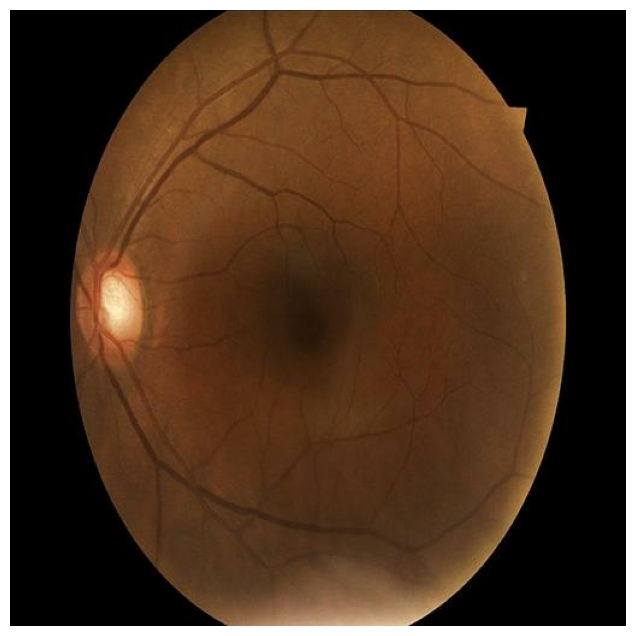

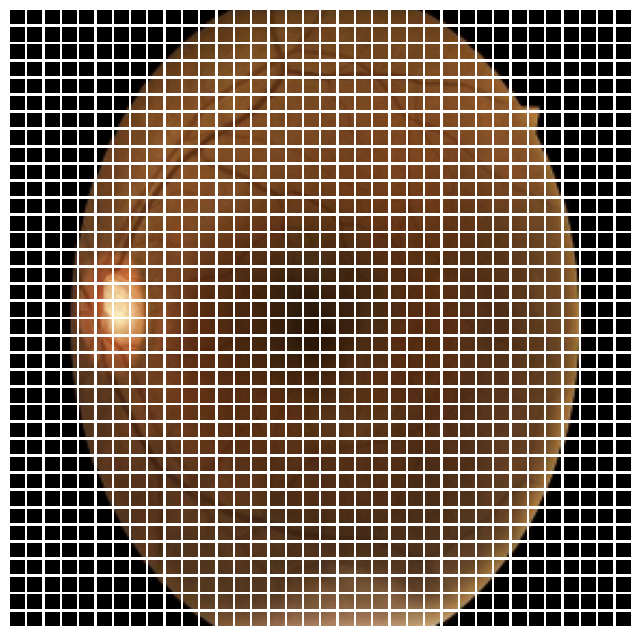

In [27]:
plt.figure(figsize=(8, 8))
image = next(iter(train_loader))[0][5]

plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

print(resized_image.shape)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
#print(n)

plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis("off")

(1, 256, 256, 3)
Image size: 256 X 256
Patch size: 7 X 7
Patches per image: 1296
Elements per patch: 147


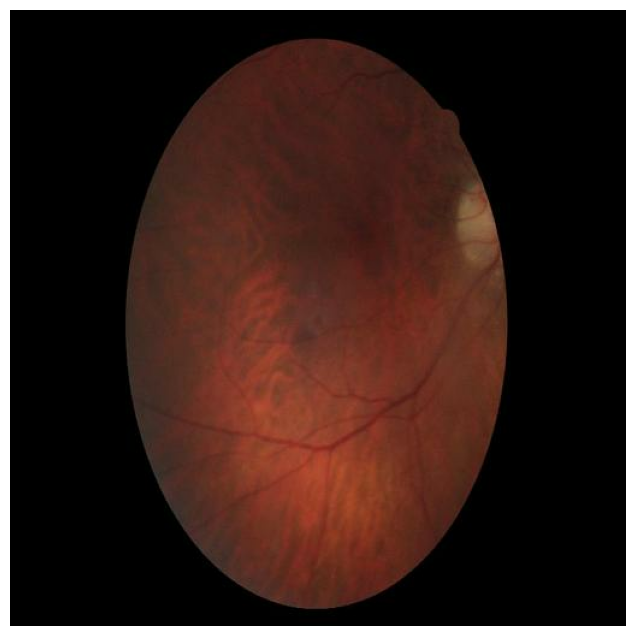

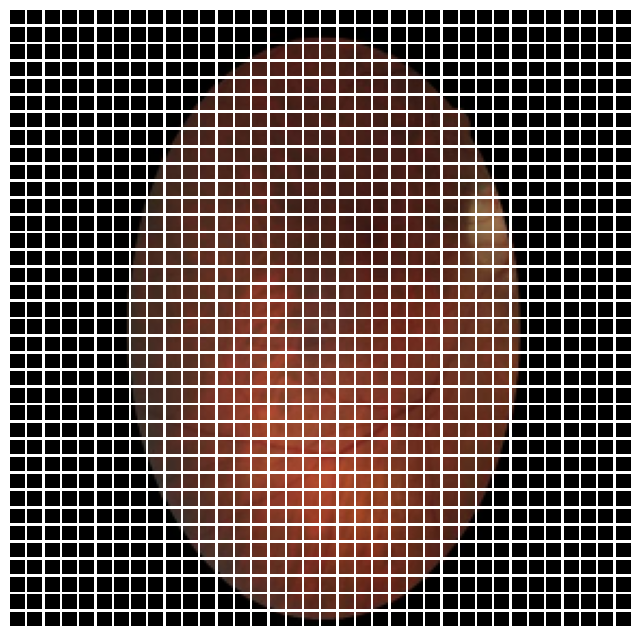

In [28]:
plt.figure(figsize=(8, 8))
image = next(iter(train_loader))[0][5]

plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

print(resized_image.shape)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
#print(n)

plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis("off")

## The patch encoding layer

The **PatchEncoder** layer will linearly transform a **patch** by projecting it into a vector of size **projection_dim**. In addition, it adds a learnable position embedding to the projected vector.

In [29]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units = projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )
        
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encode = self.projection(patch) + self.position_embedding(positions)
        return encode

##  The ViT model

The ViT model consists of multiple Transformer blocks, which use the **layers.MultiHeadAttention layer** as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a **[batch_size, num_patches, projection_dim]** tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.<br>
Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929), which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with **layers.Flatten()** and used as the image representation input to the classifier head. Note that the **layers.GlobalAveragePooling1D** layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

In [30]:
def vit_model():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.BatchNormalization()(encoded_patches)
        # create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.BatchNormalization()(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
        
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization()(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation='softmax')(features)
    # create keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [38]:
def experiment(model):
    optimizer = keras.optimizers.Adam(
        learning_rate=learning_rate
    )
    
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.AUC( name="AUC"),
        ],
     )
    checkpoint_filepath = "ViT.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(train_loader ,
                        batch_size=batch_size,
                        epochs=100,
                        validation_data=test_loader,
                        callbacks=[checkpoint_callback],
                        steps_per_epoch = 10)
    model.load_weights(checkpoint_filepath)
    _, accuracy, auc = model.evaluate(test_loader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test AUC: {round(auc * 100, 2)}%")

    return history

In [39]:
vit_classifier = vit_model()
vit_classifier.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 256, 256,  │          7 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_3 (Patches) │ (None, None, 147) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_1     │ (None, 1296, 64)  │     92,416 │ patches_3[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1296, 64)  │        256 │ patch_encoder_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1296, 64)  │     66,368 │ batch_normalizat… │
│ (MultiHeadAttentio… │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 1296, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1296, 64)  │        256 │ add_16[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1296, 128) │      8,320 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 1296, 128) │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1296, 64)  │      8,256 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 1296, 64)  │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 1296, 64)  │          0 │ dropout_29[0][0], │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1296, 64)  │        256 │ add_17[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1296, 64)  │     66,368 │ batch_normalizat… │
│ (MultiHeadAttentio… │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 1296, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1296, 64)  │        256 │ add_18[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1296, 128) │      8,320 │ batch_normalizat

 Total params: 5,406,860 (20.63 MB)

 Trainable params: 5,404,805 (20.62 MB)

 Non-trainable params: 2,055 (8.03 KB)

In [40]:
history = experiment(vit_classifier)

Epoch 1/100


10/10 ━━━━━━━━━━━━━━━━━━━━ 463s 47s/step - AUC: 0.6298 - accuracy: 0.2820 - loss: 2.9728 - val_AUC: 0.8176 - val_accuracy: 0.7206 - val_loss: 1.7808
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 424s 46s/step - AUC: 0.5818 - accuracy: 0.3009 - loss: 5.2156 - val_AUC: 0.7967 - val_accuracy: 0.5606 - val_loss: 1.2949
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 422s 46s/step - AUC: 0.6364 - accuracy: 0.3794 - loss: 3.2186 - val_AUC: 0.8260 - val_accuracy: 0.7197 - val_loss: 1.2256
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 424s 46s/step - AUC: 0.7715 - accuracy: 0.4847 - loss: 1.9156 - val_AUC: 0.8120 - val_accuracy: 0.7324 - val_loss: 1.2462
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 415s 45s/step - AUC: 0.7164 - accuracy: 0.4130 - loss: 2.2638 - val_AUC: 0.7696 - val_accuracy: 0.6844 - val_loss: 1.3587
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - AUC: 0.6751 - accuracy: 0.3244 - loss: 1.7720

KeyboardInterrupt: 

## Load the model

In [41]:
vit_classifier.load_weights("ViT.weights.h5")

In [4]:
!mkdir -p saved_model
vit_classifier.save('saved_model/newmodel')

A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


NameError: name 'vit_classifier' is not defined

## Download the saved model

In [2]:
import shutil
folder_path = "./saved_model"
shutil.make_archive(folder_path, 'zip', folder_path)

'e:\\VisionTransformer\\saved_model.zip'

In [3]:
from IPython.display import FileLink

zip_file_path = folder_path + '.zip'

FileLink(zip_file_path)

e:\VisionTransformer\saved_model.zip

## Model Performance Visulization

dict_keys(['AUC', 'accuracy', 'loss', 'val_AUC', 'val_accuracy', 'val_loss'])


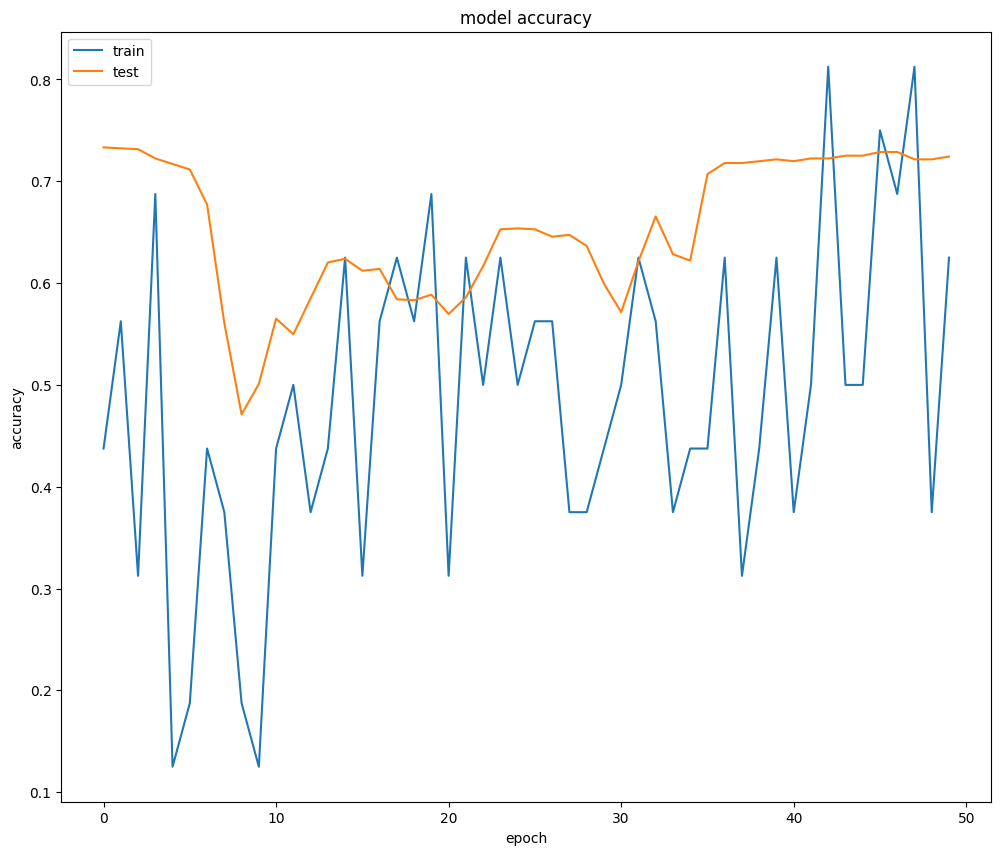

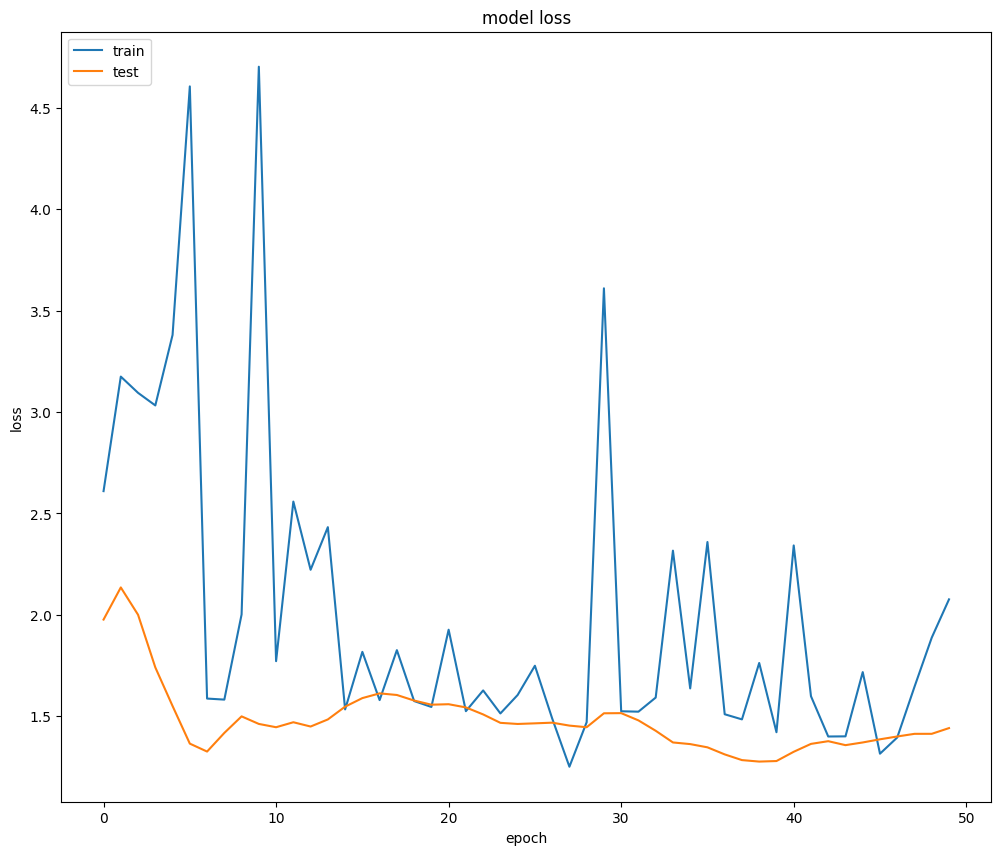

In [42]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(12,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

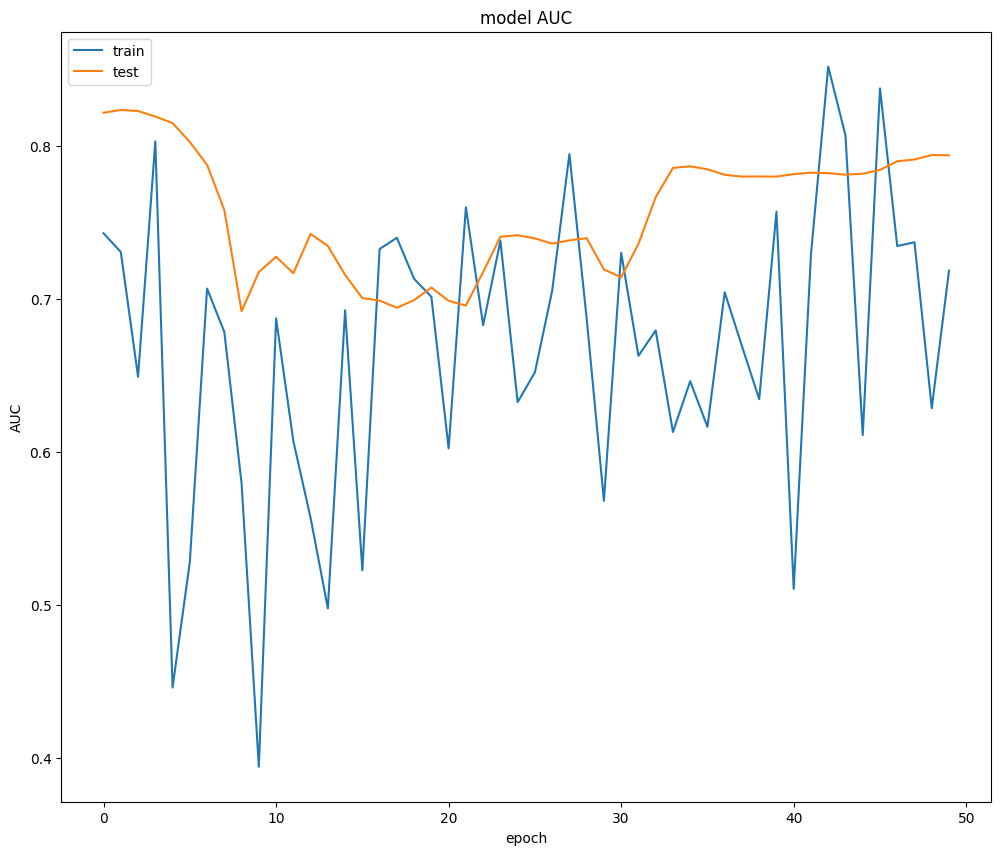

In [37]:
# summarize history for loss
plt.figure(figsize=(12,10))
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [71]:
def get_img_array(img):
    
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

## The Grad-CAM algorithm

In [72]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
        
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## superimposed visualization

In [73]:
classes.values()

dict_values(['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'])

In [74]:
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4, preds=[0,0,0,0,0], plot=None):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    plot.imshow(superimposed_img)
    plot.set(title =
        " No DR: \
        {:.3f}\nMild: \
        {:.3f}\nModerate: \
        {:.3f}\nSevere: \
        {:.3f}\nProliferative: \
        {:.3f}".format(preds[0], \
                    preds[1], \
                    preds[2], \
                    preds[3],
                    preds[4])
    )
    plot.axis('off')

## Implement Grad CAM

In [75]:
# As in layer_normalization (LayerNorma (None, 1296, 64) ) 
#the last dim is 1296 so 36x36 for heatmap
np.sqrt(1296)

36.0

In [77]:
test_image = next(iter(test_loader))[0][5]
# Prepare image
img_array =get_img_array(test_image)

last_conv_layer_name = 'data_augmentation'
# Remove last layer's softmax
vit_classifier.layers[-1].activation = None
# Print what the top predicted class is
preds = vit_classifier.predict(img_array)
print("Predicted:\n" + "No DR: \
    {p1}\nMild: {p2}\nModerate: \
    {p3}\nSevere: \
    {p4}\nProliferative: {p5}".format(p1=preds[0][0], \
                                            p2=preds[0][1],p3=preds[0][2],p4=preds[0][3],p5=preds[0][4]))
# Generate class activation heatmap
heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

heatmap = np.reshape(heatmap, (36,36))
# Display heatmap
plt.matshow(heatmap)

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
Predicted:
No DR:     0.06225547194480896
Mild: -0.03812877833843231
Moderate:     -0.0073510403744876385
Severe:     -0.04324023425579071
Proliferative: -0.062036335468292236


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m2172337075696\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        ...,\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]]]], dtype=float32)\n  • training=None\n  • mask=None'

## Heat-Map Visualization over Test-set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


C:\Users\IDREES AHMAD\AppData\Local\Temp\ipykernel_12724\4135188422.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


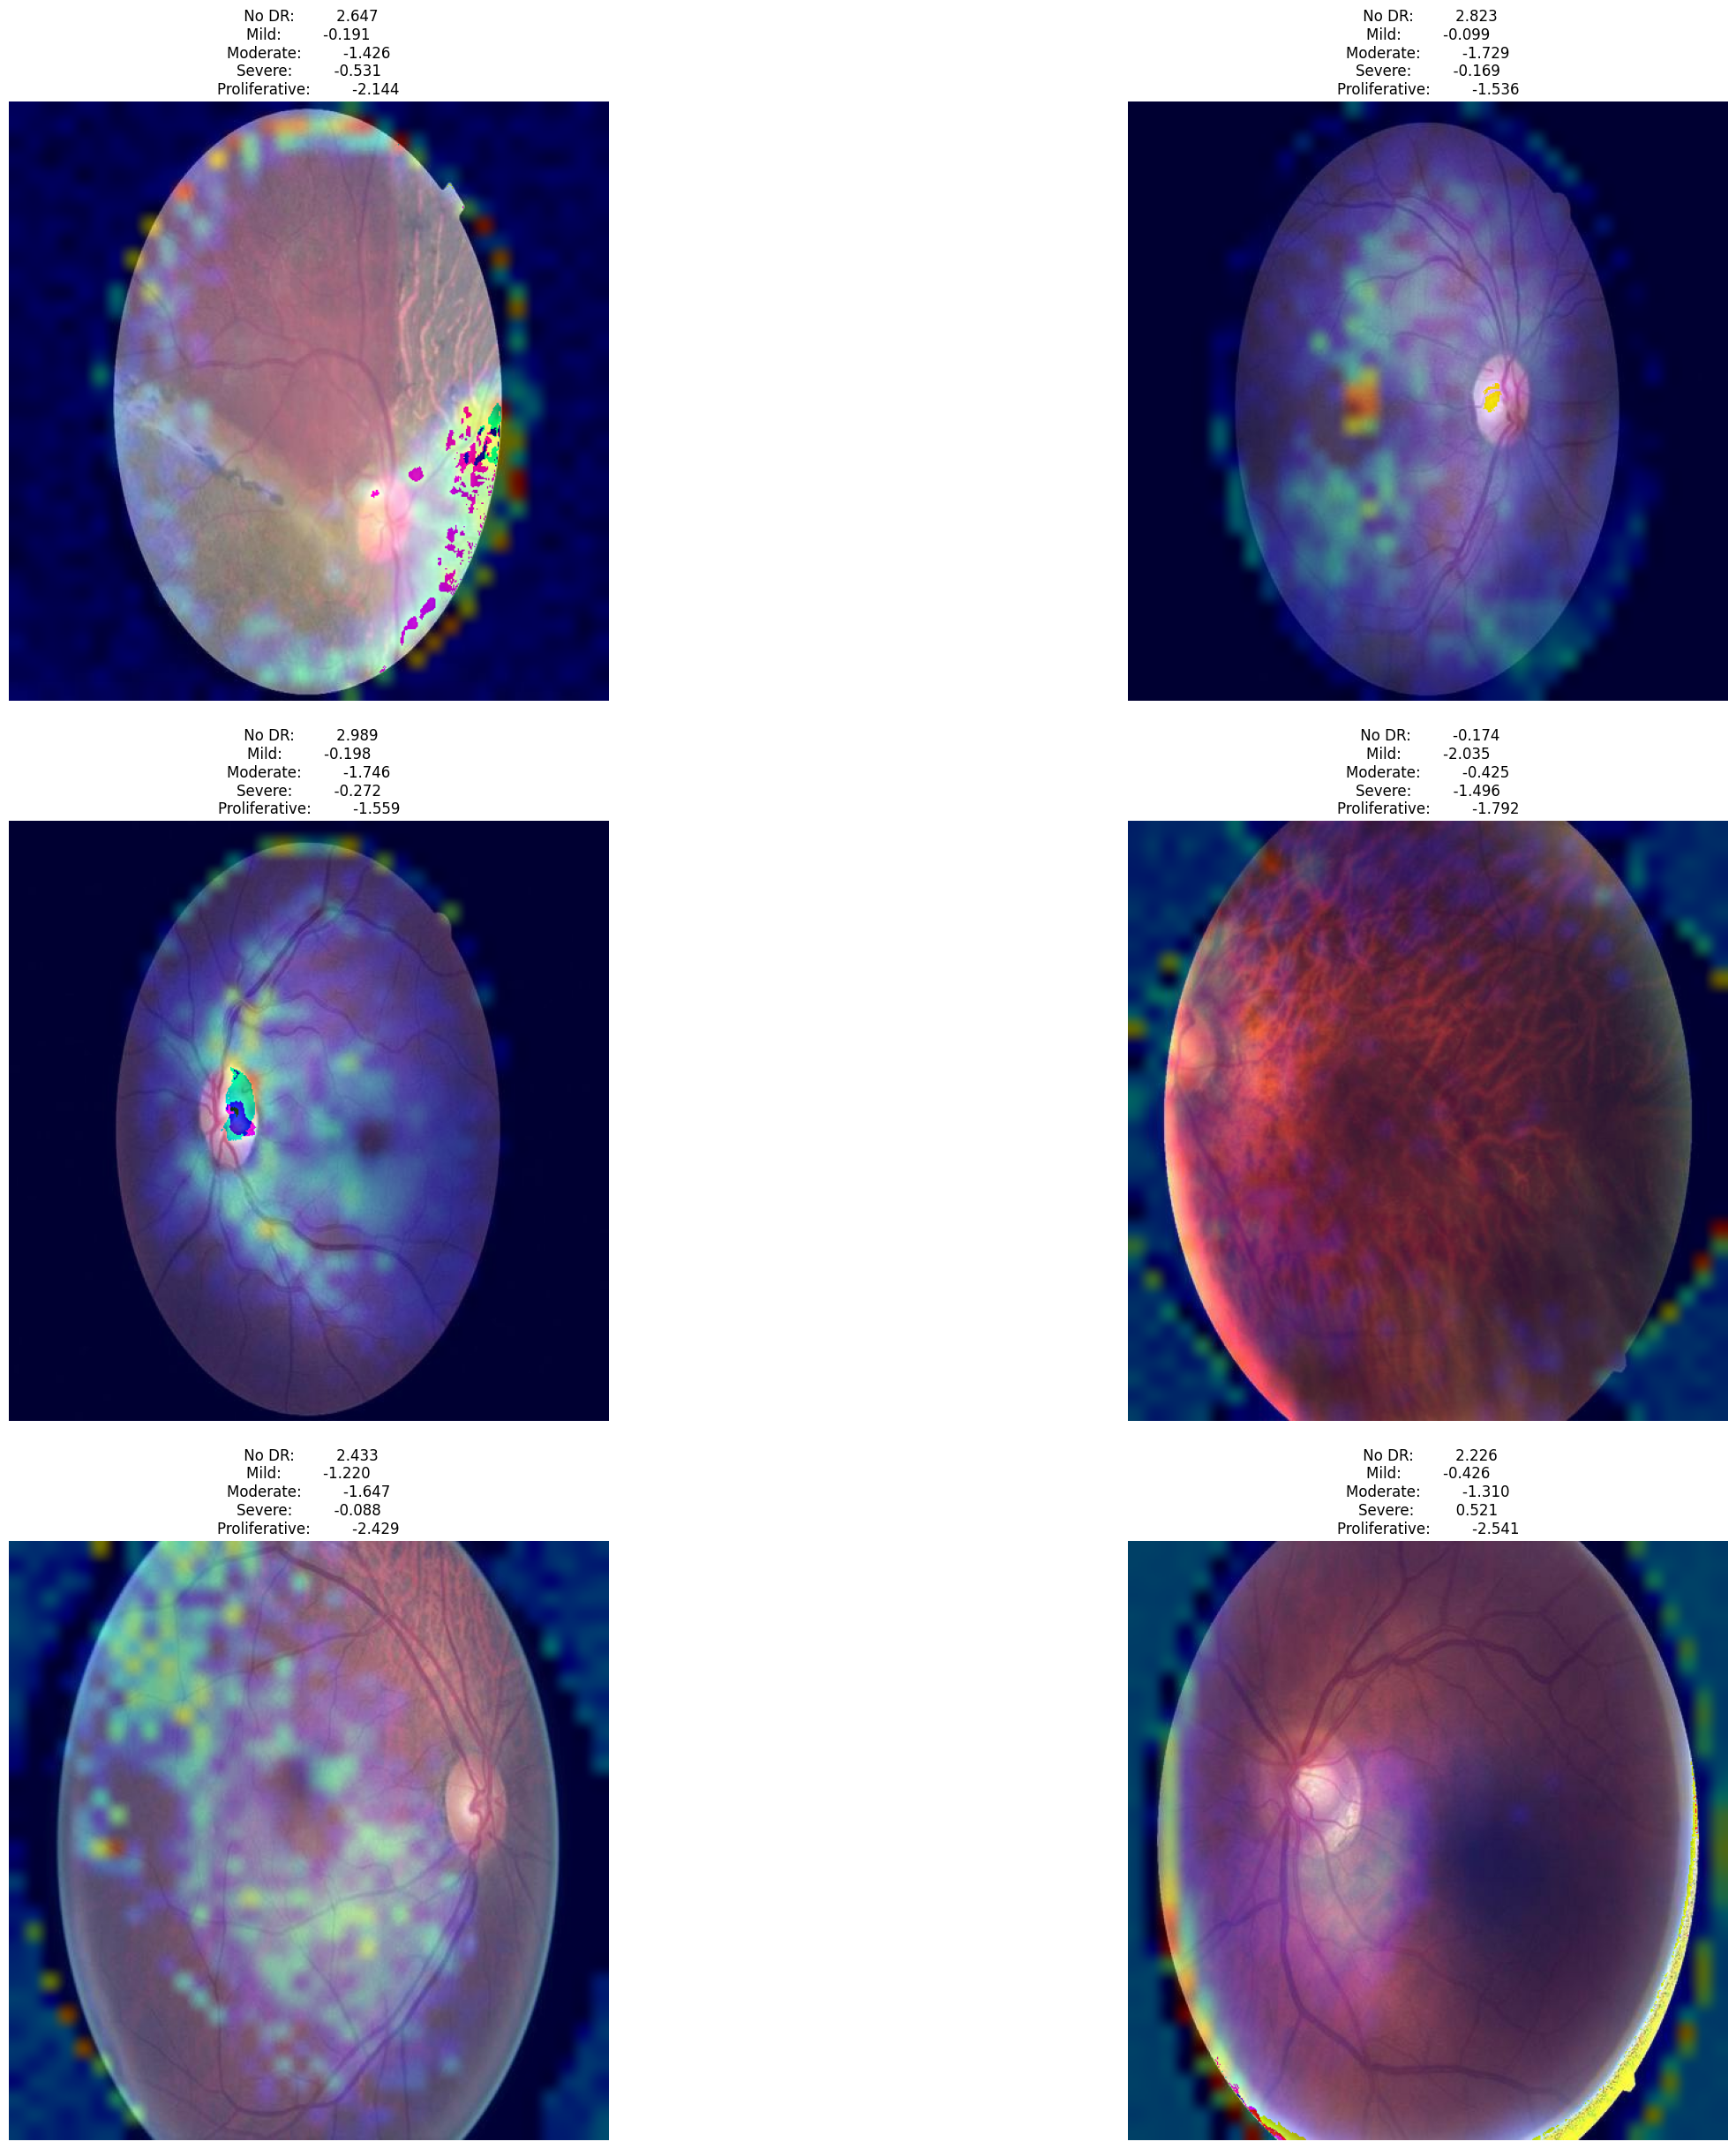

In [63]:
fig, axis = plt.subplots(3, 2, figsize=(30, 30))
for images, ax in zip(next(iter(test_loader))[0][:6], axis.flat):
    img_array = get_img_array(images)
    # Remove last layer's softmax
    vit_classifier.layers[-1].activation = None
    # Print what the top predicted class is
    preds = vit_classifier.predict(img_array)
    heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

    heatmap = np.reshape(heatmap, (36,36))
    display_gradcam(images, heatmap, preds=preds[0], plot=ax)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


C:\Users\IDREES AHMAD\AppData\Local\Temp\ipykernel_12724\4135188422.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


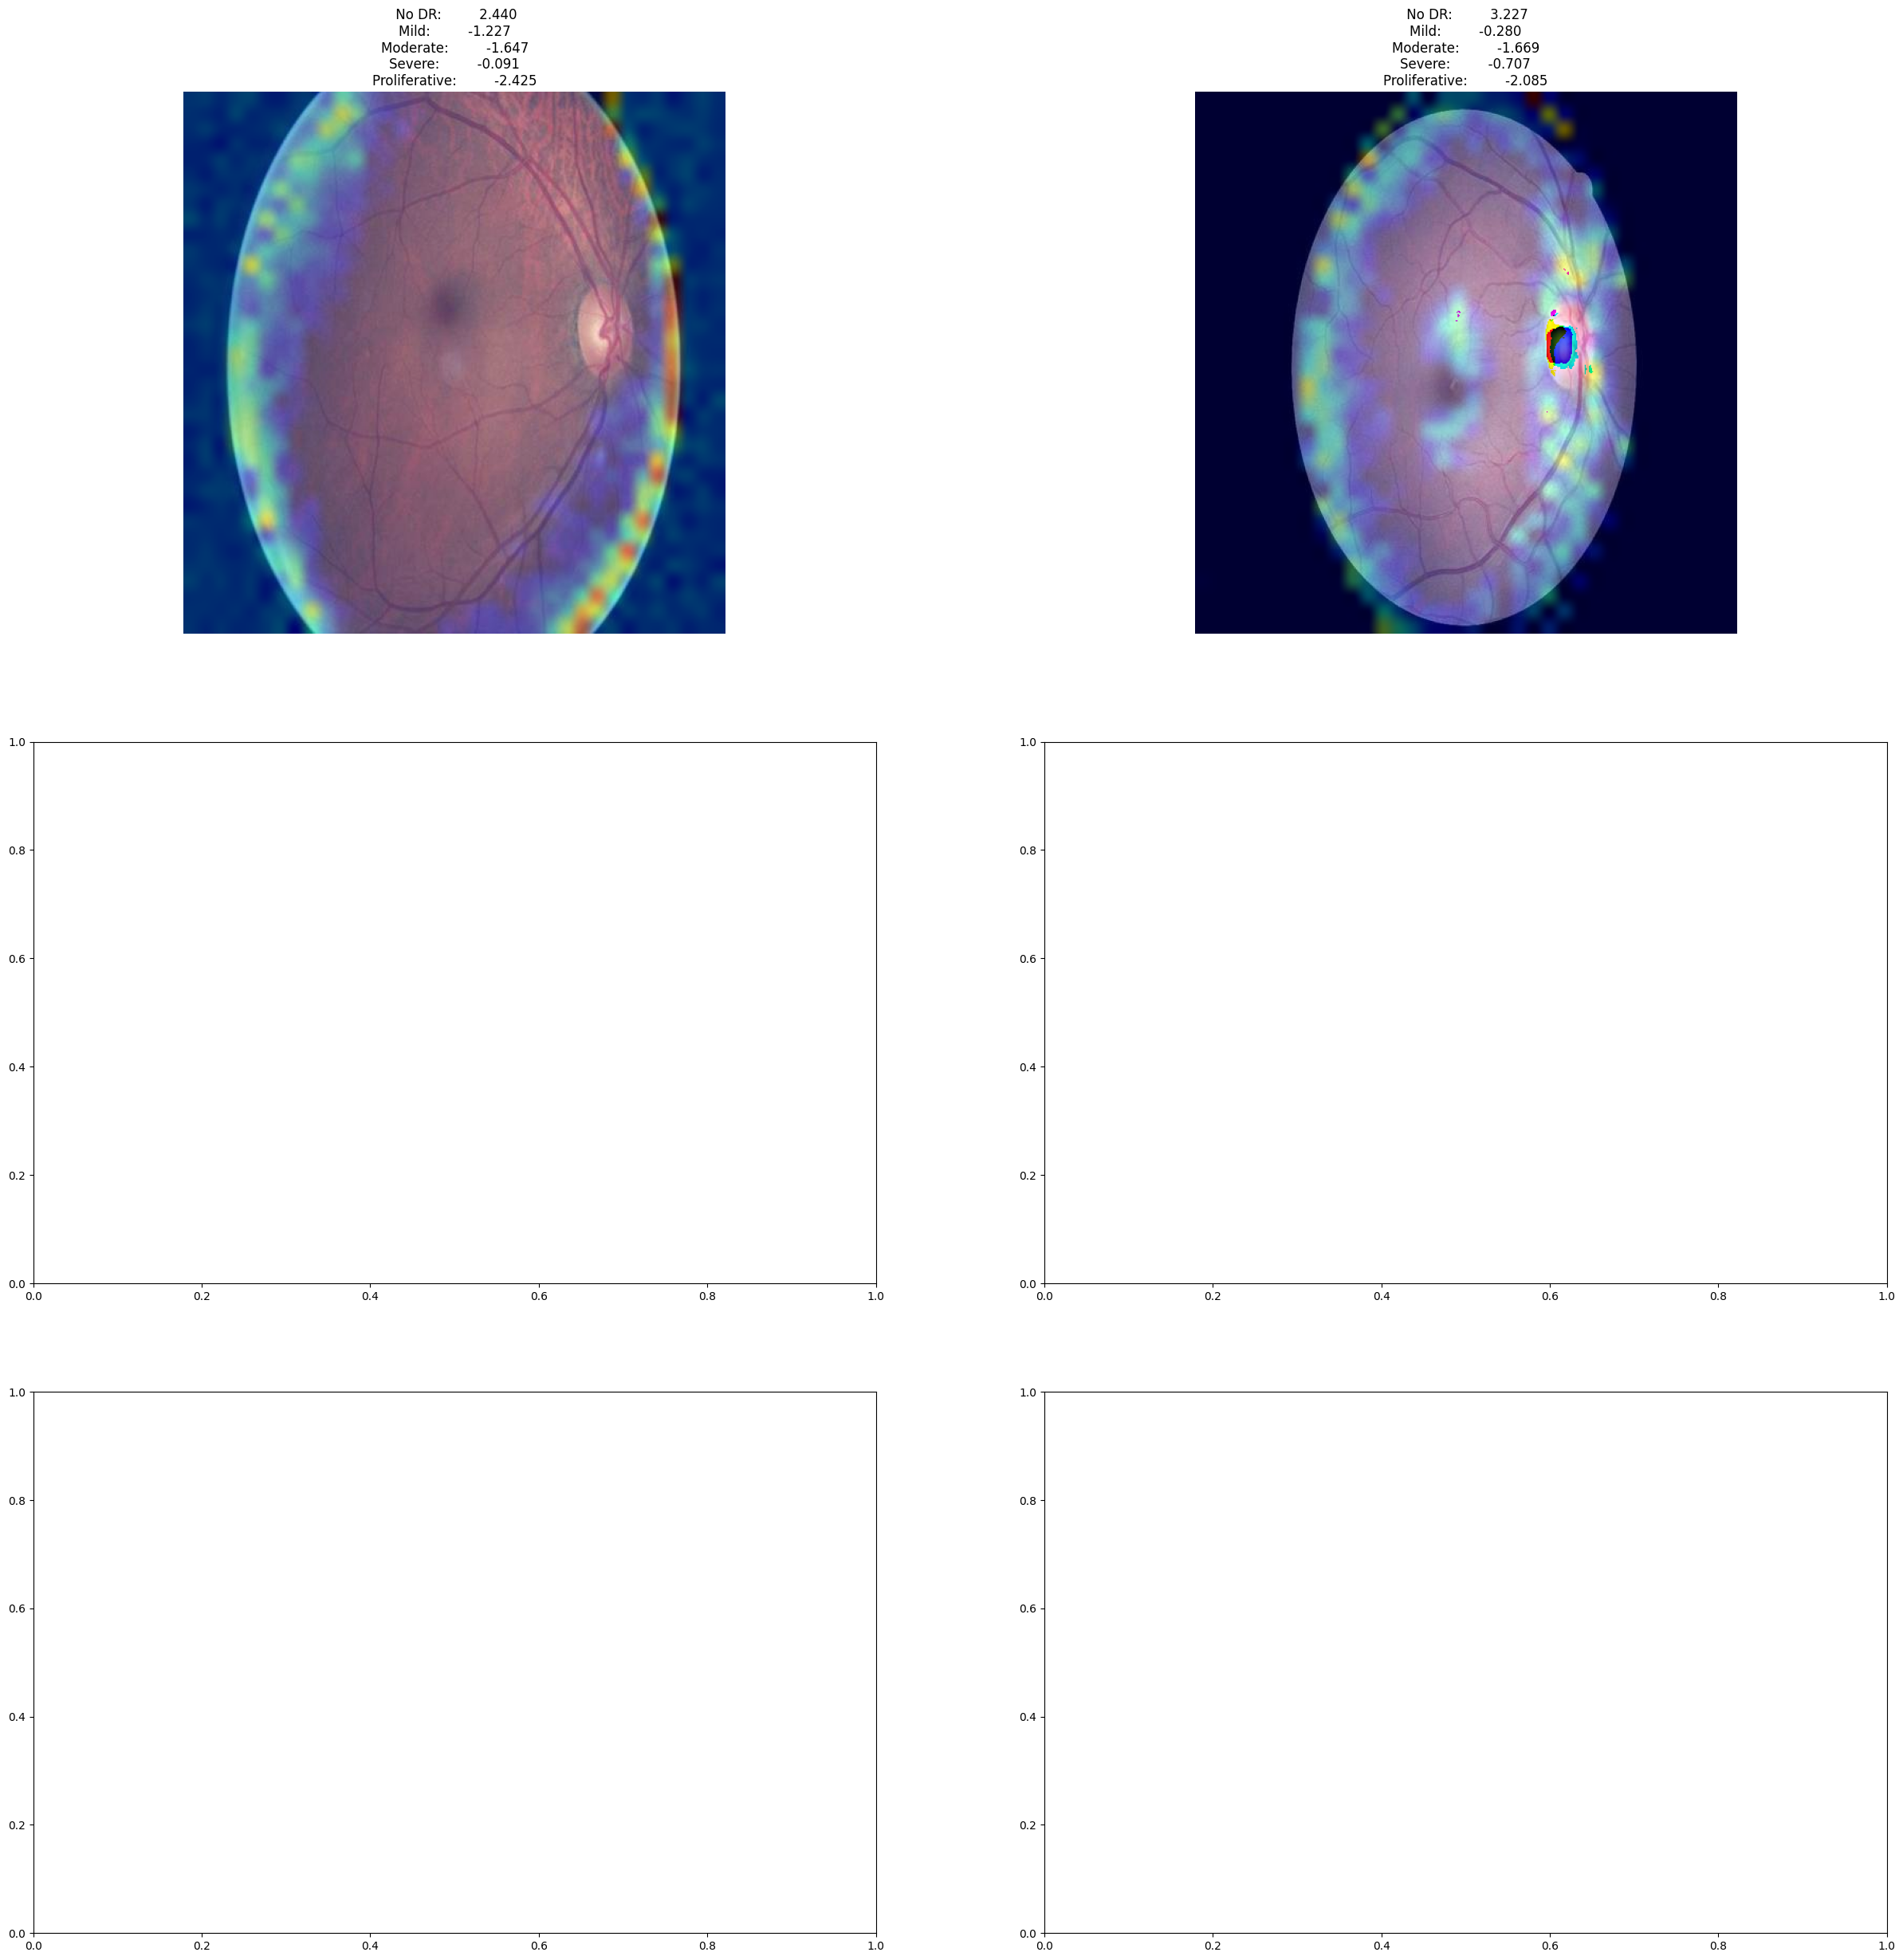

In [64]:
fig, axis = plt.subplots(3, 2, figsize=(30, 30))
for images, ax in zip(next(iter(test_loader))[0][6:12], axis.flat):
    img_array = get_img_array(images)
    # Remove last layer's softmax
    vit_classifier.layers[-1].activation = None
    # Print what the top predicted class is
    preds = vit_classifier.predict(img_array)
    heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

    heatmap = np.reshape(heatmap, (36,36))
    display_gradcam(images, heatmap, preds=preds[0], plot=ax)